In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from glob import glob
import os, cv2
from tqdm import tqdm
import tensorflow as tf
seed = 2022
tf.random.set_seed(seed)
np.random.seed(seed)

In [33]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 1451086901153087834,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 6269894656
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 17339215096146492327
 physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 2070 SUPER, pci bus id: 0000:07:00.0, compute capability: 7.5"]

In [2]:
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Embedding, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical

이미지 확인

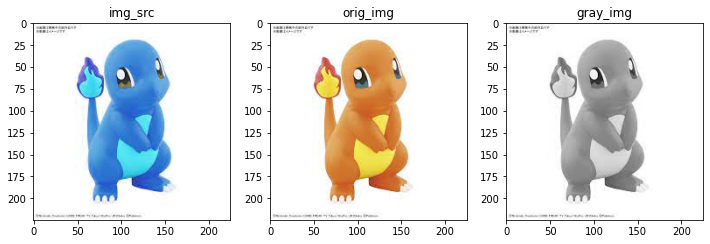

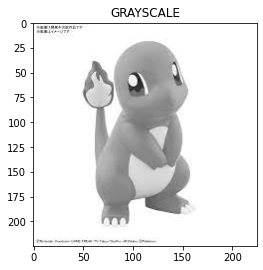

In [4]:
img_path = "C:/workspace/04.SecondProject/images"
img_cha = "pie"
img_src = cv2.imread(f"{img_path}/{img_cha}/{img_cha} (1).jpg", cv2.IMREAD_COLOR)
orig_img = cv2.cvtColor(img_src, cv2.COLOR_BGR2RGB)
gray_img = cv2.cvtColor(img_src, cv2.COLOR_BGR2GRAY)

plt.figure(figsize=(12,8))
plt.subplot(1,3,3)
plt.title("gray_img")
plt.imshow(gray_img, cmap='gray')
plt.subplot(1,3,2)
plt.title("orig_img")
plt.imshow(orig_img)
plt.subplot(1,3,1)
plt.title("img_src")
plt.imshow(img_src)

plt.figure(figsize=(4,8))
plt.title("GRAYSCALE")
img = cv2.imread(f"{img_path}/{img_cha}/{img_cha} (1).jpg", cv2.IMREAD_GRAYSCALE)
plt.imshow(img, cmap='gray')

In [5]:
cha_list = ['isang', 'jammanbo', 'evee', 'pie', 'squirtle', 'pikachu', 'jiwoo', 'leeseul']
X = []
y = []
err = []

for idx, img_cha in enumerate(tqdm(cha_list)):
    filepath = f"{img_path}/{img_cha}"
    for fname in os.listdir(filepath):
        img = cv2.imread(f'{filepath}/{fname}', cv2.IMREAD_COLOR)
        try:
            gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            resize_img = cv2.resize(gray_img, dsize=(128, 128), interpolation= cv2.INTER_LINEAR)
            
            blur = cv2.GaussianBlur(resize_img, ksize = (5, 5), sigmaX = 0)
            
            X.append(blur / 256)
            y.append(idx)

        except:
            err.append(fname)
            continue
        
X = np.array(X)
y = np.array(y)

print('\n에러:','None' if len(err) == 0 else err)

100%|██████████| 8/8 [00:07<00:00,  1.01it/s]


에러: None


In [6]:
X.shape, y.shape

((4000, 128, 128), (4000,))

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.2, stratify = y, random_state = seed
)

# X_train, X_valid, Y_train, Y_valid = train_test_split(
#     X_train, y_train, stratify = y_train, test_size = 0.2, random_state = seed
# )
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((3200, 128, 128), (800, 128, 128), (3200,), (800,))

In [8]:
# X_train, X_test 정규화 (0 ~ 1), 이미지 차원 변경: 2차원 --> 3차원
X_train = X_train.reshape(-1, 128, 128, 1) / 255.
X_test = X_test.reshape(-1, 128, 128, 1) / 255.
X_train.shape, X_test.shape

((3200, 128, 128, 1), (800, 128, 128, 1))

In [9]:
# y_data: one-hot encoding
Y_train = to_categorical(y_train)
Y_test = to_categorical(y_test)
Y_train.shape, Y_test.shape

((3200, 8), (800, 8))

In [10]:
with tf.device("/device:CPU:0"):
    model = Sequential([
    Conv2D(32, (3, 3), input_shape = (128,128,1), padding = 'same', activation = 'relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Conv2D(64, (3, 3), padding = 'same', activation = 'relu'),
    Conv2D(64, (3, 3), activation = 'relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(8, activation = 'softmax')
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 32)      320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 64)        18496     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 62, 62, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 31, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 31, 31, 64)        0

In [11]:
model.compile('adam', 'categorical_crossentropy', ['accuracy'])

model_path = './gray_delNois_adam.h5'
mc = ModelCheckpoint(model_path, moniter = 'val_loss', verbose = 0, save_best_only = True)
es = EarlyStopping(patience = 15)

In [12]:
from sklearn.model_selection import train_test_split
X_train, X_valid, Y_train, Y_valid = train_test_split(
    X_train, Y_train, stratify=Y_train, test_size=0.2, random_state=seed
)

### 부풀리기 적용 O

In [13]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=10,          # randomly rotate images in the range 15 degree
    width_shift_range=0.1,      # randomly shift images horizontally 
    height_shift_range=0.1,     # randomly shift images vertically
    shear_range=0.1,            # 도형의 기울기
    zoom_range=[0.8,1.2],       # 0.8~1.2 배 크기로 임의로 확대/축소
    horizontal_flip=True,       # randomly flip images
    vertical_flip=False,        # randomly flip images
    fill_mode='nearest'         # set mode for filling points outside the input boundaries
)


In [14]:
datagen.fit(X_train)

In [15]:
with tf.device("/device:GPU:0"):
    hist1 = model.fit(
    datagen.flow(X_train, Y_train, batch_size=32),
    validation_data=(X_valid, Y_valid), epochs = 100, callbacks=[mc, es]
    )

Epoch 1/100
80/80 [==============================] - 8s 57ms/step - loss: 2.0812 - accuracy: 0.1180 - val_loss: 2.0795 - val_accuracy: 0.1250

Epoch 00001: val_loss improved from inf to 2.07947, saving model to .\gray_delNois_adam.h5
Epoch 2/100
80/80 [==============================] - 5s 56ms/step - loss: 2.0799 - accuracy: 0.1219 - val_loss: 2.0795 - val_accuracy: 0.1250

Epoch 00002: val_loss improved from 2.07947 to 2.07946, saving model to .\gray_delNois_adam.h5
Epoch 3/100
80/80 [==============================] - 5s 56ms/step - loss: 2.0799 - accuracy: 0.1148 - val_loss: 2.0795 - val_accuracy: 0.1250

Epoch 00003: val_loss did not improve from 2.07946
Epoch 4/100
80/80 [==============================] - 4s 56ms/step - loss: 2.0796 - accuracy: 0.1238 - val_loss: 2.0795 - val_accuracy: 0.1250

Epoch 00004: val_loss improved from 2.07946 to 2.07945, saving model to .\gray_delNois_adam.h5
Epoch 5/100
80/80 [==============================] - 4s 55ms/step - loss: 2.0796 - accuracy: 0.1

In [16]:
best_model = load_model(model_path)
best_model.evaluate(X_test, Y_test)

25/25 [==============================] - 0s 6ms/step - loss: 2.0794 - accuracy: 0.1250


[2.0794427394866943, 0.125]

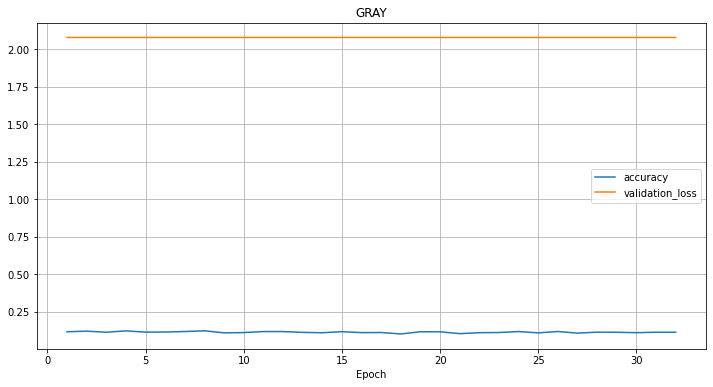

In [17]:
y_acc = hist1.history['accuracy']
y_vloss = hist1.history['val_loss']
xs = np.arange(1, len(y_acc) + 1)

plt.figure(figsize = (12, 6))
plt.plot(xs, y_acc, label = 'accuracy')
plt.plot(xs, y_vloss, label = 'validation_loss')
plt.xlabel('Epoch')
plt.title('GRAY')
plt.legend(), plt.grid()
plt.show()

### 부풀리기 적용 X

In [18]:
model_path2 = './gray_delNois_NoGen_adam.h5'
mc2 = ModelCheckpoint(model_path2, moniter = 'val_loss', verbose = 1, save_best_only = True)
es2 = EarlyStopping(patience = 10)

In [19]:
with tf.device("/device:GPU:0"):
    hist2 = model.fit(
    X_train, Y_train, validation_split=0.2, epochs=100, batch_size=200,
    callbacks=[mc2,es2])

Epoch 1/100
11/11 [==============================] - 5s 212ms/step - loss: 2.0794 - accuracy: 0.1240 - val_loss: 2.0795 - val_accuracy: 0.1289

Epoch 00001: val_loss improved from inf to 2.07947, saving model to .\gray_delNois_NoGen_adam.h5
Epoch 2/100
11/11 [==============================] - 1s 123ms/step - loss: 2.0794 - accuracy: 0.1240 - val_loss: 2.0795 - val_accuracy: 0.1230

Epoch 00002: val_loss did not improve from 2.07947
Epoch 3/100
11/11 [==============================] - 1s 123ms/step - loss: 2.0794 - accuracy: 0.1255 - val_loss: 2.0796 - val_accuracy: 0.1230

Epoch 00003: val_loss did not improve from 2.07947
Epoch 4/100
11/11 [==============================] - 1s 123ms/step - loss: 2.0794 - accuracy: 0.1260 - val_loss: 2.0796 - val_accuracy: 0.1113

Epoch 00004: val_loss did not improve from 2.07947
Epoch 5/100
11/11 [==============================] - 1s 122ms/step - loss: 2.0794 - accuracy: 0.1284 - val_loss: 2.0797 - val_accuracy: 0.1113

Epoch 00005: val_loss did not 

In [21]:
best_model2 = load_model(model_path2)
best_model2.evaluate(X_test, Y_test)

25/25 [==============================] - 1s 8ms/step - loss: 2.0794 - accuracy: 0.1250


[2.079442024230957, 0.125]

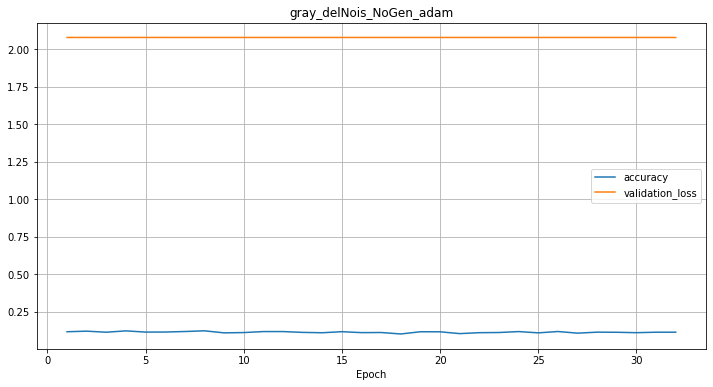

In [22]:
y_acc = hist1.history['accuracy']
y_vloss = hist1.history['val_loss']
xs = np.arange(1, len(y_acc) + 1)

plt.figure(figsize = (12, 6))
plt.plot(xs, y_acc, label = 'accuracy')
plt.plot(xs, y_vloss, label = 'validation_loss')
plt.xlabel('Epoch')
plt.title('gray_delNois_NoGen_adam')
plt.legend(), plt.grid()
plt.show()

### 다른 모델링

- 부풀리기랑 컴파일 바꿈

In [29]:
datagen2 = ImageDataGenerator(
    rescale=1/255.,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.5,
    zoom_range=[0.8,1.5],
    horizontal_flip=True,
    vertical_flip=False,
    fill_mode='nearest'
)

In [30]:
datagen2.fit(X_train)

In [38]:
with tf.device("/device:CPU:0"):
    model = Sequential([
    Conv2D(32, (3, 3), input_shape = (128,128,1), padding = 'same', activation = 'relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Conv2D(64, (3, 3), padding = 'same', activation = 'relu'),
    Conv2D(64, (3, 3), activation = 'relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(8, activation = 'softmax')
])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 128, 128, 32)      320       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 64, 64, 64)        18496     
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 62, 62, 64)        36928     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 31, 31, 64)        0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 31, 31, 64)       

In [39]:
model.compile(
    optimizer=RMSprop(learning_rate=0.0001, decay=1e-6),
    loss='categorical_crossentropy', metrics=['accuracy']
)
model_path3 = './gray_delNois_rms.h5'
mc3 = ModelCheckpoint(model_path3, moniter = 'val_loss', verbose = 0, save_best_only = True)
es3 = EarlyStopping(patience = 15)

In [33]:
with tf.device("/device:GPU:0"):
    hist3 = model.fit(
    datagen2.flow(X_train, Y_train, batch_size=32),
    validation_data=(X_valid, Y_valid), epochs = 100, callbacks=[mc3, es3]
    )

Epoch 1/100
80/80 [==============================] - 11s 122ms/step - loss: 2.0796 - accuracy: 0.1199 - val_loss: 2.0794 - val_accuracy: 0.1250

Epoch 00001: val_loss improved from inf to 2.07944, saving model to .\gray_delNois_rms.h5
Epoch 2/100
80/80 [==============================] - 10s 121ms/step - loss: 2.0795 - accuracy: 0.1160 - val_loss: 2.0794 - val_accuracy: 0.1250

Epoch 00002: val_loss improved from 2.07944 to 2.07944, saving model to .\gray_delNois_rms.h5
Epoch 3/100
80/80 [==============================] - 10s 120ms/step - loss: 2.0795 - accuracy: 0.1211 - val_loss: 2.0794 - val_accuracy: 0.1250

Epoch 00003: val_loss did not improve from 2.07944
Epoch 4/100
80/80 [==============================] - 10s 121ms/step - loss: 2.0795 - accuracy: 0.1180 - val_loss: 2.0794 - val_accuracy: 0.1250

Epoch 00004: val_loss did not improve from 2.07944
Epoch 5/100
80/80 [==============================] - 10s 121ms/step - loss: 2.0795 - accuracy: 0.1191 - val_loss: 2.0794 - val_accurac

In [34]:
best_model = load_model(model_path3)
best_model.evaluate(X_test, Y_test)

25/25 [==============================] - 1s 13ms/step - loss: 2.0794 - accuracy: 0.1250


[2.079442024230957, 0.125]

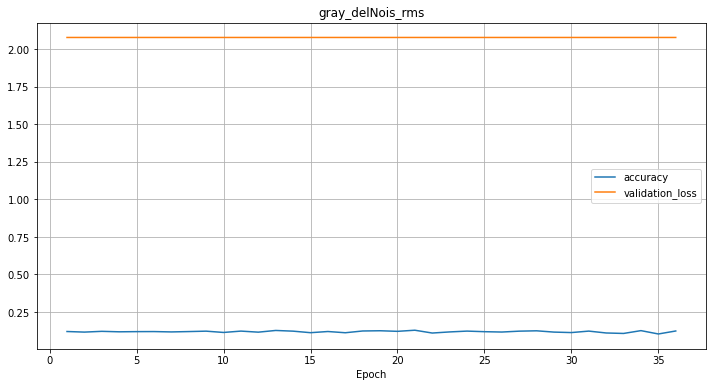

In [35]:
y_acc = hist3.history['accuracy']
y_vloss = hist3.history['val_loss']
xs = np.arange(1, len(y_acc) + 1)

plt.figure(figsize = (12, 6))
plt.plot(xs, y_acc, label = 'accuracy')
plt.plot(xs, y_vloss, label = 'validation_loss')
plt.xlabel('Epoch')
plt.title('gray_delNois_rms')
plt.legend(), plt.grid()
plt.show()

#### 부풀리기만 더 바꿈

In [40]:
datagen4 = ImageDataGenerator(
    featurewise_center=False,   # set input mean to 0 over the dataset
    samplewise_center=False,    # set each sample mean to 0
    featurewise_std_normalization=False,    # divide inputs by std of dataset
    samplewise_std_normalization=False,     # divide each input by its std
    zca_whitening=False,    # apply ZCA whitening
    zca_epsilon=1e-06,      # epsilon for ZCA whitening
    rotation_range=0,       # randomly rotate images in the range (deg 0 to 180)
    width_shift_range=0.1,  # randomly shift images horizontally
    height_shift_range=0.1, # randomly shift images vertically
    shear_range=0.,         # set range for random shear
    zoom_range=0.1,         # set range for random zoom
    channel_shift_range=0., # set range for random channel shifts
    fill_mode='nearest',    # set mode for filling points outside the input boundaries
    cval=0.,                # value used for fill_mode = "constant"
    horizontal_flip=True,   # randomly flip images
    vertical_flip=False,    # randomly flip images
    rescale=None,           # set rescaling factor (applied before any other transformation)
    preprocessing_function=None,    # set function that will be applied on each input
    data_format=None,       # image data format, either "channels_first" or "channels_last"
    validation_split=0.0    # fraction of images reserved for validation
)

In [41]:
model_path4 = './gray_NewdelNois_rms.h5'
mc4 = ModelCheckpoint(model_path4, moniter = 'val_loss', verbose = 0, save_best_only = True)
es4 = EarlyStopping(patience = 10)

In [42]:
with tf.device("/device:GPU:0"):
    hist4 = model.fit(
    datagen4.flow(X_train, Y_train, batch_size=32), verbose=0,
    validation_data=(X_valid, Y_valid), epochs = 100, callbacks=[mc4, es4]
    )

Epoch 1/100
80/80 [==============================] - 11s 120ms/step - loss: 2.0798 - accuracy: 0.1242 - val_loss: 2.0791 - val_accuracy: 0.1281
Epoch 2/100
80/80 [==============================] - 9s 118ms/step - loss: 2.0787 - accuracy: 0.1512 - val_loss: 2.0759 - val_accuracy: 0.1578
Epoch 3/100
80/80 [==============================] - 10s 121ms/step - loss: 2.0729 - accuracy: 0.1543 - val_loss: 2.0651 - val_accuracy: 0.1422
Epoch 4/100
80/80 [==============================] - 10s 120ms/step - loss: 2.0556 - accuracy: 0.1766 - val_loss: 2.0338 - val_accuracy: 0.2516
Epoch 5/100
80/80 [==============================] - 10s 119ms/step - loss: 2.0284 - accuracy: 0.2039 - val_loss: 2.0030 - val_accuracy: 0.2609
Epoch 6/100
80/80 [==============================] - 9s 118ms/step - loss: 2.0089 - accuracy: 0.2141 - val_loss: 1.9490 - val_accuracy: 0.2953
Epoch 7/100
80/80 [==============================] - 9s 118ms/step - loss: 1.9683 - accuracy: 0.2363 - val_loss: 1.9048 - val_accuracy: 0.

In [43]:
best_model = load_model(model_path4)
best_model.evaluate(X_test, Y_test)

25/25 [==============================] - 0s 6ms/step - loss: 1.2740 - accuracy: 0.5725


[1.2739533185958862, 0.5724999904632568]

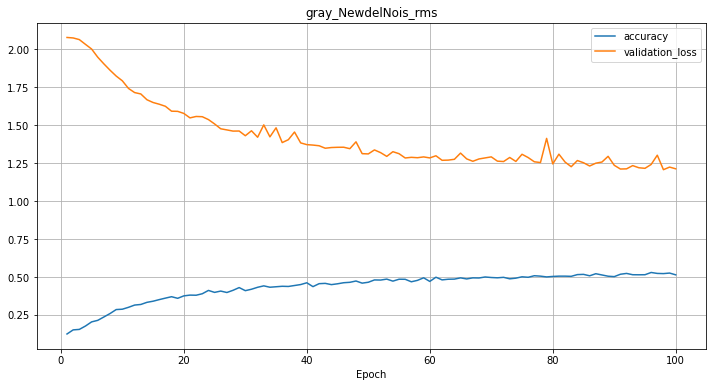

In [44]:
y_acc = hist4.history['accuracy']
y_vloss = hist4.history['val_loss']
xs = np.arange(1, len(y_acc) + 1)

plt.figure(figsize = (12, 6))
plt.plot(xs, y_acc, label = 'accuracy')
plt.plot(xs, y_vloss, label = 'validation_loss')
plt.xlabel('Epoch')
plt.title('gray_NewdelNois_rms')
plt.legend(), plt.grid()
plt.show()

- 에포크, 배치사이즈 증가

In [57]:
model_path5 = './gray_NewdelNois_rms2.h5'
mc5 = ModelCheckpoint(model_path5, moniter = 'val_loss', verbose = 1, save_best_only = True)
es5 = EarlyStopping(patience = 20)
with tf.device("/device:GPU:0"):
    hist5 = model.fit(
    datagen4.flow(X_train, Y_train, batch_size=12), verbose=1,
    validation_data=(X_valid, Y_valid), epochs = 200, callbacks=[mc5, es5]
    )

Epoch 1/200
214/214 [==============================] - 26s 120ms/step - loss: 1.3405 - accuracy: 0.5332 - val_loss: 1.2126 - val_accuracy: 0.5797
Epoch 2/200
214/214 [==============================] - 25s 119ms/step - loss: 1.3457 - accuracy: 0.5375 - val_loss: 1.1997 - val_accuracy: 0.6141
Epoch 3/200
214/214 [==============================] - 25s 119ms/step - loss: 1.3178 - accuracy: 0.5285 - val_loss: 1.1720 - val_accuracy: 0.6187
Epoch 4/200
214/214 [==============================] - 25s 119ms/step - loss: 1.3311 - accuracy: 0.5289 - val_loss: 1.2132 - val_accuracy: 0.6078
Epoch 5/200
214/214 [==============================] - 25s 119ms/step - loss: 1.3532 - accuracy: 0.5332 - val_loss: 1.1998 - val_accuracy: 0.5938
Epoch 6/200
214/214 [==============================] - 26s 120ms/step - loss: 1.3360 - accuracy: 0.5344 - val_loss: 1.2101 - val_accuracy: 0.5969
Epoch 7/200
214/214 [==============================] - 26s 120ms/step - loss: 1.3358 - accuracy: 0.5398 - val_loss: 1.2003 -

In [58]:
best_model = load_model(model_path5)
best_model.evaluate(X_test, Y_test)

25/25 [==============================] - 0s 7ms/step - loss: 1.1986 - accuracy: 0.6025


[1.1986076831817627, 0.6025000214576721]

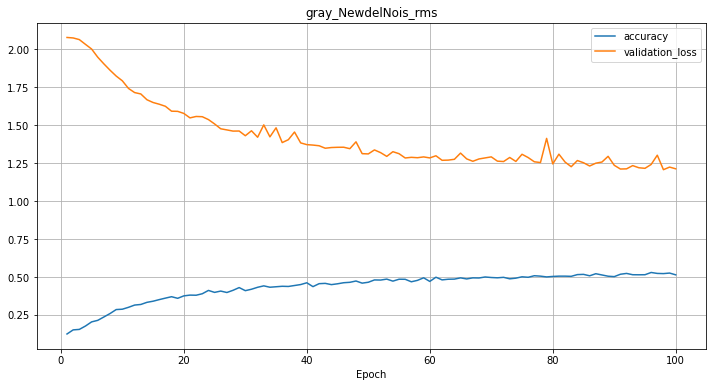

In [59]:
y_acc = hist4.history['accuracy']
y_vloss = hist4.history['val_loss']
xs = np.arange(1, len(y_acc) + 1)

plt.figure(figsize = (12, 6))
plt.plot(xs, y_acc, label = 'accuracy')
plt.plot(xs, y_vloss, label = 'validation_loss')
plt.xlabel('Epoch')
plt.title('gray_NewdelNois_rms')
plt.legend(), plt.grid()
plt.show()

SGD도 활용해보고자 함
- batch size
https://inhovation97.tistory.com/32
